<a href="https://colab.research.google.com/github/fmejias/CienciasDeLosDatosTEC/blob/master/AprendizajeAutomatico/TP2/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ciencias de los Datos:
# Aprendizaje automático

## Trabajo práctico 2

- Professor: M.Sc.Saul Calderon.

- Students: 
    - Felipe Alberto Mejías Loría, Instituto Tecnológico de Costa Rica. 
    - María Auxiliadora Mora, Instituto Tecnológico de Costa Rica  

- July 28th, 2019   

In [0]:
# Libraries required for the exercises
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pandas;
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split as tts

## 1. Implementación de clasificadores lineales de dos clases. (40 puntos)

Sample data linearly separable


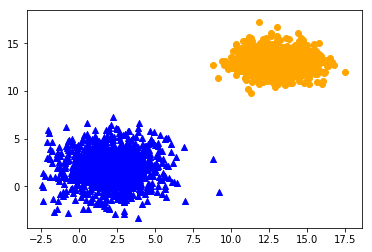

>epoch=0, cost=9684.673
>epoch=1, cost=9311.653
>epoch=2, cost=9284.022
>epoch=3, cost=9242.577
>epoch=4, cost=9201.130
>epoch=5, cost=9049.159
>epoch=6, cost=8247.858
>epoch=7, cost=-0.001
>epoch=8, cost=-0.001
>epoch=9, cost=-0.001
>epoch=10, cost=-0.001
>epoch=11, cost=-0.001
>epoch=12, cost=-0.001
>epoch=13, cost=-0.001
>epoch=14, cost=-0.001
>epoch=15, cost=-0.001
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0.001
>epoch=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


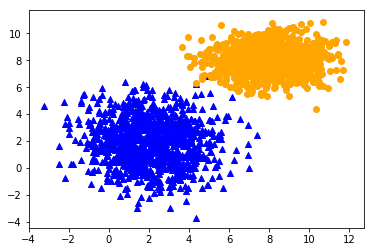

>epoch=0, cost=9643.227
>epoch=1, cost=9560.332
>epoch=2, cost=9463.624
>epoch=3, cost=9394.546
>epoch=4, cost=8855.740
>epoch=5, cost=9560.334
>epoch=6, cost=9394.546
>epoch=7, cost=9297.837
>epoch=8, cost=8911.003
>epoch=9, cost=5954.484
>epoch=10, cost=9560.334
>epoch=11, cost=9256.391
>epoch=12, cost=9049.158
>epoch=13, cost=8358.383
>epoch=14, cost=3992.682
>epoch=15, cost=9560.334
>epoch=16, cost=9173.498
>epoch=17, cost=8828.110
>epoch=18, cost=7971.548
>epoch=19, cost=4448.593
>epoch=20, cost=290.125
>epoch=21, cost=27.630
>epoch=22, cost=27.630
>epoch=23, cost=27.630
>epoch=24, cost=27.630
>epoch=25, cost=13.814
>epoch=26, cost=13.814
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>ep

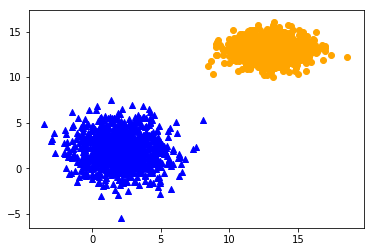

>epoch=0, cost=9933.352
>epoch=1, cost=9159.684
>epoch=2, cost=9145.868
>epoch=3, cost=9062.975
>epoch=4, cost=8952.450
>epoch=5, cost=8869.558
>epoch=6, cost=8399.829
>epoch=7, cost=4904.506
>epoch=8, cost=9809.012
>epoch=9, cost=8952.450
>epoch=10, cost=8883.373
>epoch=11, cost=8786.665
>epoch=12, cost=8524.170
>epoch=13, cost=8068.258
>epoch=14, cost=6424.211
>epoch=15, cost=400.649
>epoch=16, cost=151.969
>epoch=17, cost=69.076
>epoch=18, cost=41.445
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, c

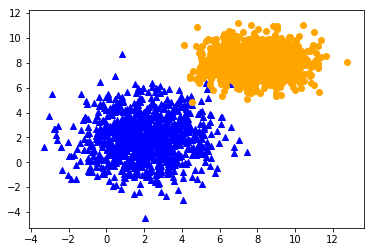

>epoch=0, cost=9822.827
>epoch=1, cost=9242.576
>epoch=2, cost=9159.684
>epoch=3, cost=8980.082
>epoch=4, cost=8607.062
>epoch=5, cost=9601.779
>epoch=6, cost=8980.082
>epoch=7, cost=8841.927
>epoch=8, cost=8620.878
>epoch=9, cost=7308.404
>epoch=10, cost=9601.779
>epoch=11, cost=8814.295
>epoch=12, cost=8676.141
>epoch=13, cost=8040.626
>epoch=14, cost=6023.562
>epoch=15, cost=8247.858
>epoch=16, cost=8607.062
>epoch=17, cost=8040.626
>epoch=18, cost=6769.600
>epoch=19, cost=1174.318
>epoch=20, cost=69.076
>epoch=21, cost=69.076
>epoch=22, cost=69.076
>epoch=23, cost=69.076
>epoch=24, cost=69.076
>epoch=25, cost=69.076
>epoch=26, cost=69.076
>epoch=27, cost=69.076
>epoch=28, cost=69.076
>epoch=29, cost=69.076
>epoch=30, cost=69.076
>epoch=31, cost=69.076
>epoch=32, cost=69.076
>epoch=33, cost=69.076
>epoch=34, cost=69.076
>epoch=35, cost=69.076
>epoch=36, cost=55.261
>epoch=37, cost=69.076
>epoch=38, cost=69.076
>epoch=39, cost=69.076
>epoch=40, cost=69.076
>epoch=41, cost=69.076
>epo

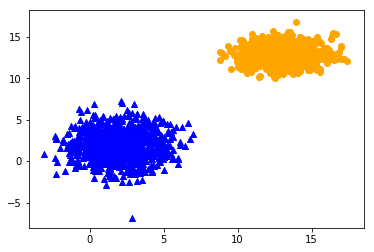

>epoch=0, cost=9615.595
>epoch=1, cost=9518.886
>epoch=2, cost=9449.809
>epoch=3, cost=9408.361
>epoch=4, cost=9380.730
>epoch=5, cost=9145.867
>epoch=6, cost=8234.044
>epoch=7, cost=9422.178
>epoch=8, cost=9380.730
>epoch=9, cost=9311.653
>epoch=10, cost=9159.683
>epoch=11, cost=8828.110
>epoch=12, cost=8289.306
>epoch=13, cost=5857.776
>epoch=14, cost=-0.001
>epoch=15, cost=-0.001
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=

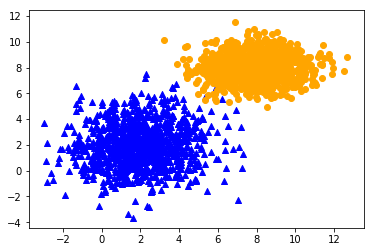

>epoch=0, cost=10099.139
>epoch=1, cost=8966.266
>epoch=2, cost=8855.741
>epoch=3, cost=8731.401
>epoch=4, cost=8386.014
>epoch=5, cost=3149.936
>epoch=6, cost=9878.090
>epoch=7, cost=8689.955
>epoch=8, cost=8565.615
>epoch=9, cost=8206.412
>epoch=10, cost=6631.443
>epoch=11, cost=9878.090
>epoch=12, cost=8565.615
>epoch=13, cost=8344.567
>epoch=14, cost=7930.103
>epoch=15, cost=6493.289
>epoch=16, cost=455.911
>epoch=17, cost=69.076
>epoch=18, cost=69.076
>epoch=19, cost=69.076
>epoch=20, cost=69.076
>epoch=21, cost=69.076
>epoch=22, cost=69.076
>epoch=23, cost=69.076
>epoch=24, cost=69.076
>epoch=25, cost=69.076
>epoch=26, cost=69.076
>epoch=27, cost=69.076
>epoch=28, cost=69.076
>epoch=29, cost=69.076
>epoch=30, cost=69.076
>epoch=31, cost=69.076
>epoch=32, cost=69.076
>epoch=33, cost=82.892
>epoch=34, cost=69.076
>epoch=35, cost=69.076
>epoch=36, cost=69.076
>epoch=37, cost=69.076
>epoch=38, cost=69.076
>epoch=39, cost=69.076
>epoch=40, cost=69.076
>epoch=41, cost=69.076
>epoch=42,

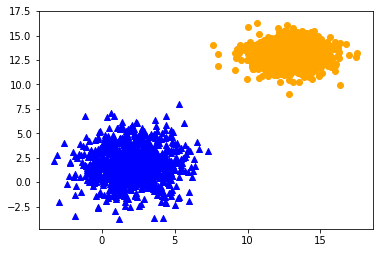

>epoch=0, cost=9809.013
>epoch=1, cost=9284.022
>epoch=2, cost=9256.392
>epoch=3, cost=9090.605
>epoch=4, cost=9049.159
>epoch=5, cost=8841.926
>epoch=6, cost=8386.014
>epoch=7, cost=3301.906
>epoch=8, cost=9657.041
>epoch=9, cost=9021.528
>epoch=10, cost=8980.081
>epoch=11, cost=8800.479
>epoch=12, cost=8593.247
>epoch=13, cost=8137.334
>epoch=14, cost=6424.211
>epoch=15, cost=262.493
>epoch=16, cost=82.892
>epoch=17, cost=27.630
>epoch=18, cost=27.630
>epoch=19, cost=27.630
>epoch=20, cost=27.630
>epoch=21, cost=27.630
>epoch=22, cost=13.814
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, co

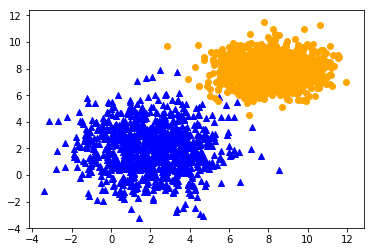

>epoch=0, cost=10016.245
>epoch=1, cost=9062.975
>epoch=2, cost=8980.081
>epoch=3, cost=8883.372
>epoch=4, cost=8551.801
>epoch=5, cost=9836.644
>epoch=6, cost=8883.372
>epoch=7, cost=8772.849
>epoch=8, cost=8551.801
>epoch=9, cost=7681.423
>epoch=10, cost=8261.675
>epoch=11, cost=8717.587
>epoch=12, cost=8441.275
>epoch=13, cost=7570.898
>epoch=14, cost=994.716
>epoch=15, cost=276.309
>epoch=16, cost=110.523
>epoch=17, cost=41.445
>epoch=18, cost=27.630
>epoch=19, cost=55.261
>epoch=20, cost=41.445
>epoch=21, cost=41.445
>epoch=22, cost=27.630
>epoch=23, cost=55.261
>epoch=24, cost=41.445
>epoch=25, cost=41.445
>epoch=26, cost=27.630
>epoch=27, cost=55.261
>epoch=28, cost=41.445
>epoch=29, cost=41.445
>epoch=30, cost=27.630
>epoch=31, cost=55.261
>epoch=32, cost=41.445
>epoch=33, cost=41.445
>epoch=34, cost=27.630
>epoch=35, cost=55.261
>epoch=36, cost=41.445
>epoch=37, cost=41.445
>epoch=38, cost=27.630
>epoch=39, cost=55.261
>epoch=40, cost=41.445
>epoch=41, cost=41.445
>epoch=42, c

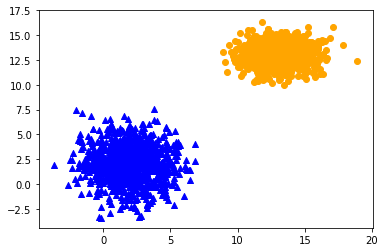

>epoch=0, cost=9463.624
>epoch=1, cost=9657.041
>epoch=2, cost=9629.410
>epoch=3, cost=9518.887
>epoch=4, cost=9422.179
>epoch=5, cost=9214.944
>epoch=6, cost=8082.073
>epoch=7, cost=6382.765
>epoch=8, cost=9366.916
>epoch=9, cost=9159.683
>epoch=10, cost=8634.694
>epoch=11, cost=6562.367
>epoch=12, cost=-0.001
>epoch=13, cost=-0.001
>epoch=14, cost=-0.001
>epoch=15, cost=-0.001
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0.0

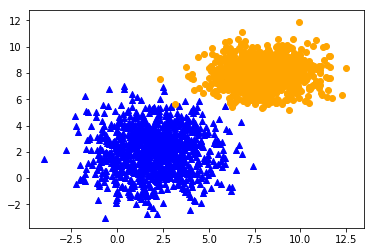

>epoch=0, cost=10057.692
>epoch=1, cost=8952.450
>epoch=2, cost=8924.818
>epoch=3, cost=8911.003
>epoch=4, cost=8524.170
>epoch=5, cost=9822.828
>epoch=6, cost=8911.003
>epoch=7, cost=8828.110
>epoch=8, cost=8537.984
>epoch=9, cost=7280.773
>epoch=10, cost=9822.828
>epoch=11, cost=8772.849
>epoch=12, cost=8607.062
>epoch=13, cost=8040.626
>epoch=14, cost=6134.085
>epoch=15, cost=9311.653
>epoch=16, cost=8634.693
>epoch=17, cost=8289.306
>epoch=18, cost=7488.006
>epoch=19, cost=4061.760
>epoch=20, cost=2500.607
>epoch=21, cost=5360.417
>epoch=22, cost=193.416
>epoch=23, cost=69.076
>epoch=24, cost=110.523
>epoch=25, cost=69.076
>epoch=26, cost=82.892
>epoch=27, cost=96.707
>epoch=28, cost=69.076
>epoch=29, cost=96.707
>epoch=30, cost=69.076
>epoch=31, cost=96.707
>epoch=32, cost=69.076
>epoch=33, cost=96.707
>epoch=34, cost=96.707
>epoch=35, cost=69.076
>epoch=36, cost=96.707
>epoch=37, cost=69.076
>epoch=38, cost=96.707
>epoch=39, cost=82.892
>epoch=40, cost=82.892
>epoch=41, cost=82.8

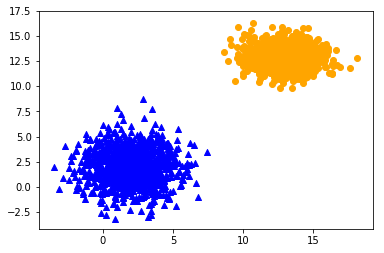

>epoch=0, cost=9864.274
>epoch=1, cost=9201.129
>epoch=2, cost=9173.498
>epoch=3, cost=9118.236
>epoch=4, cost=9076.789
>epoch=5, cost=8938.634
>epoch=6, cost=8399.829
>epoch=7, cost=2486.791
>epoch=8, cost=9657.042
>epoch=9, cost=9035.343
>epoch=10, cost=8938.634
>epoch=11, cost=8897.188
>epoch=12, cost=8745.218
>epoch=13, cost=8151.150
>epoch=14, cost=6355.134
>epoch=15, cost=165.785
>epoch=16, cost=96.707
>epoch=17, cost=27.630
>epoch=18, cost=27.630
>epoch=19, cost=27.630
>epoch=20, cost=27.630
>epoch=21, cost=13.814
>epoch=22, cost=13.814
>epoch=23, cost=13.814
>epoch=24, cost=13.814
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, co

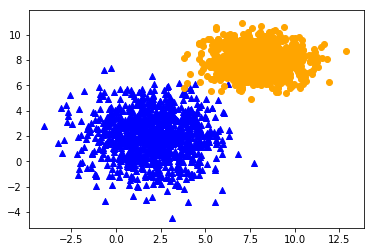

>epoch=0, cost=9809.013
>epoch=1, cost=9297.839
>epoch=2, cost=9284.022
>epoch=3, cost=9214.944
>epoch=4, cost=8537.984
>epoch=5, cost=9560.332
>epoch=6, cost=9228.761
>epoch=7, cost=9076.789
>epoch=8, cost=8551.801
>epoch=9, cost=4572.934
>epoch=10, cost=9560.332
>epoch=11, cost=9062.974
>epoch=12, cost=8759.033
>epoch=13, cost=8026.811
>epoch=14, cost=2956.519
>epoch=15, cost=9560.332
>epoch=16, cost=8911.004
>epoch=17, cost=8551.801
>epoch=18, cost=7874.840
>epoch=19, cost=4117.022
>epoch=20, cost=9532.701
>epoch=21, cost=8703.771
>epoch=22, cost=8344.567
>epoch=23, cost=7515.636
>epoch=24, cost=3757.819
>epoch=25, cost=193.416
>epoch=26, cost=41.445
>epoch=27, cost=41.445
>epoch=28, cost=27.630
>epoch=29, cost=27.630
>epoch=30, cost=41.445
>epoch=31, cost=27.630
>epoch=32, cost=27.630
>epoch=33, cost=27.630
>epoch=34, cost=27.630
>epoch=35, cost=41.445
>epoch=36, cost=27.630
>epoch=37, cost=27.630
>epoch=38, cost=27.630
>epoch=39, cost=41.445
>epoch=40, cost=27.630
>epoch=41, cost=

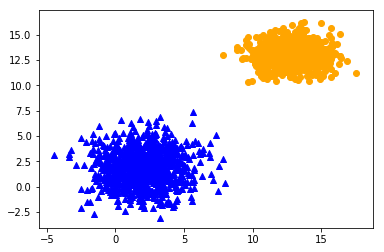

>epoch=0, cost=9657.041
>epoch=1, cost=9325.470
>epoch=2, cost=9270.206
>epoch=3, cost=9214.944
>epoch=4, cost=9090.605
>epoch=5, cost=8883.373
>epoch=6, cost=8234.044
>epoch=7, cost=621.697
>epoch=8, cost=-0.001
>epoch=9, cost=-0.001
>epoch=10, cost=-0.001
>epoch=11, cost=-0.001
>epoch=12, cost=-0.001
>epoch=13, cost=-0.001
>epoch=14, cost=-0.001
>epoch=15, cost=-0.001
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0.001
>epoch

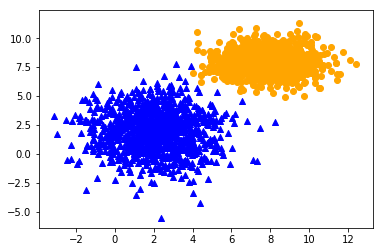

>epoch=0, cost=9974.799
>epoch=1, cost=9118.236
>epoch=2, cost=9104.421
>epoch=3, cost=8938.635
>epoch=4, cost=8579.430
>epoch=5, cost=9822.828
>epoch=6, cost=8938.635
>epoch=7, cost=8828.111
>epoch=8, cost=8579.430
>epoch=9, cost=7418.928
>epoch=10, cost=9822.828
>epoch=11, cost=8800.479
>epoch=12, cost=8620.878
>epoch=13, cost=8123.520
>epoch=14, cost=6355.134
>epoch=15, cost=3149.936
>epoch=16, cost=6907.755
>epoch=17, cost=386.833
>epoch=18, cost=27.630
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42

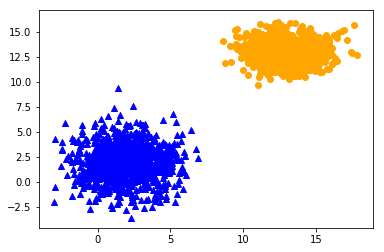

>epoch=0, cost=9712.304
>epoch=1, cost=9187.314
>epoch=2, cost=9187.314
>epoch=3, cost=9118.236
>epoch=4, cost=8993.896
>epoch=5, cost=8897.188
>epoch=6, cost=8275.490
>epoch=7, cost=5180.816
>epoch=8, cost=9491.256
>epoch=9, cost=8938.634
>epoch=10, cost=8911.003
>epoch=11, cost=8800.479
>epoch=12, cost=8482.723
>epoch=13, cost=7861.024
>epoch=14, cost=6341.318
>epoch=15, cost=1326.288
>epoch=16, cost=55.261
>epoch=17, cost=27.630
>epoch=18, cost=27.630
>epoch=19, cost=27.630
>epoch=20, cost=13.814
>epoch=21, cost=13.814
>epoch=22, cost=13.814
>epoch=23, cost=13.814
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, c

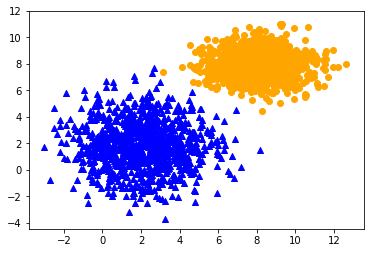

>epoch=0, cost=10085.323
>epoch=1, cost=8911.003
>epoch=2, cost=8883.372
>epoch=3, cost=8786.664
>epoch=4, cost=8468.907
>epoch=5, cost=3744.003
>epoch=6, cost=9905.722
>epoch=7, cost=8745.217
>epoch=8, cost=8676.140
>epoch=9, cost=8261.675
>epoch=10, cost=6659.075
>epoch=11, cost=9905.722
>epoch=12, cost=8676.140
>epoch=13, cost=8372.198
>epoch=14, cost=7930.102
>epoch=15, cost=6534.736
>epoch=16, cost=676.959
>epoch=17, cost=27.630
>epoch=18, cost=27.630
>epoch=19, cost=27.630
>epoch=20, cost=27.630
>epoch=21, cost=69.076
>epoch=22, cost=27.630
>epoch=23, cost=69.076
>epoch=24, cost=27.630
>epoch=25, cost=82.892
>epoch=26, cost=27.630
>epoch=27, cost=27.630
>epoch=28, cost=110.523
>epoch=29, cost=27.630
>epoch=30, cost=27.630
>epoch=31, cost=55.261
>epoch=32, cost=69.076
>epoch=33, cost=27.630
>epoch=34, cost=96.707
>epoch=35, cost=27.630
>epoch=36, cost=27.630
>epoch=37, cost=82.892
>epoch=38, cost=27.630
>epoch=39, cost=27.630
>epoch=40, cost=82.892
>epoch=41, cost=27.630
>epoch=42

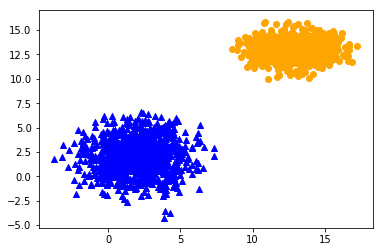

>epoch=0, cost=9960.982
>epoch=1, cost=9145.867
>epoch=2, cost=9090.605
>epoch=3, cost=9090.605
>epoch=4, cost=9007.712
>epoch=5, cost=8883.372
>epoch=6, cost=8289.306
>epoch=7, cost=179.600
>epoch=8, cost=13.814
>epoch=9, cost=13.814
>epoch=10, cost=-0.001
>epoch=11, cost=-0.001
>epoch=12, cost=-0.001
>epoch=13, cost=-0.001
>epoch=14, cost=-0.001
>epoch=15, cost=-0.001
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0.001
>epoch

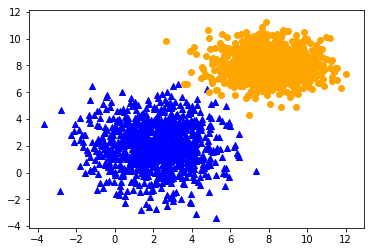

>epoch=0, cost=9960.983
>epoch=1, cost=9173.498
>epoch=2, cost=9118.236
>epoch=3, cost=9007.712
>epoch=4, cost=8662.323
>epoch=5, cost=9795.196
>epoch=6, cost=9007.712
>epoch=7, cost=8924.819
>epoch=8, cost=8689.954
>epoch=9, cost=7225.511
>epoch=10, cost=9795.196
>epoch=11, cost=8911.004
>epoch=12, cost=8703.770
>epoch=13, cost=8178.781
>epoch=14, cost=5885.407
>epoch=15, cost=9795.196
>epoch=16, cost=8759.032
>epoch=17, cost=8468.906
>epoch=18, cost=7722.870
>epoch=19, cost=5153.185
>epoch=20, cost=207.231
>epoch=21, cost=55.261
>epoch=22, cost=55.261
>epoch=23, cost=55.261
>epoch=24, cost=55.261
>epoch=25, cost=69.076
>epoch=26, cost=55.261
>epoch=27, cost=69.076
>epoch=28, cost=41.445
>epoch=29, cost=55.261
>epoch=30, cost=41.445
>epoch=31, cost=55.261
>epoch=32, cost=55.261
>epoch=33, cost=55.261
>epoch=34, cost=55.261
>epoch=35, cost=55.261
>epoch=36, cost=55.261
>epoch=37, cost=55.261
>epoch=38, cost=55.261
>epoch=39, cost=27.630
>epoch=40, cost=27.630
>epoch=41, cost=27.630
>ep

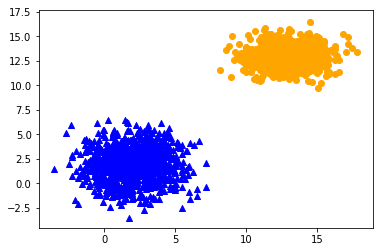

>epoch=0, cost=9601.779
>epoch=1, cost=9408.362
>epoch=2, cost=9353.100
>epoch=3, cost=9270.207
>epoch=4, cost=9173.498
>epoch=5, cost=8883.373
>epoch=6, cost=8234.043
>epoch=7, cost=27.630
>epoch=8, cost=-0.001
>epoch=9, cost=-0.001
>epoch=10, cost=-0.001
>epoch=11, cost=-0.001
>epoch=12, cost=-0.001
>epoch=13, cost=-0.001
>epoch=14, cost=-0.001
>epoch=15, cost=-0.001
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0.001
>epoch=

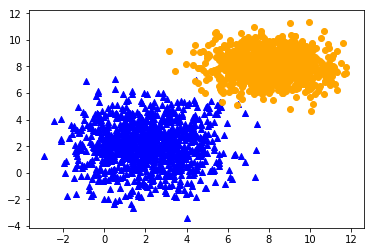

>epoch=0, cost=9919.536
>epoch=1, cost=9242.575
>epoch=2, cost=9145.867
>epoch=3, cost=9035.343
>epoch=4, cost=8689.956
>epoch=5, cost=9767.565
>epoch=6, cost=9035.343
>epoch=7, cost=8938.634
>epoch=8, cost=8717.587
>epoch=9, cost=7377.480
>epoch=10, cost=9767.565
>epoch=11, cost=8924.818
>epoch=12, cost=8745.218
>epoch=13, cost=8206.412
>epoch=14, cost=5885.407
>epoch=15, cost=9767.565
>epoch=16, cost=8814.295
>epoch=17, cost=8565.615
>epoch=18, cost=7916.286
>epoch=19, cost=5167.000
>epoch=20, cost=138.154
>epoch=21, cost=27.630
>epoch=22, cost=27.630
>epoch=23, cost=27.630
>epoch=24, cost=27.630
>epoch=25, cost=27.630
>epoch=26, cost=27.630
>epoch=27, cost=27.630
>epoch=28, cost=27.630
>epoch=29, cost=27.630
>epoch=30, cost=27.630
>epoch=31, cost=27.630
>epoch=32, cost=27.630
>epoch=33, cost=27.630
>epoch=34, cost=27.630
>epoch=35, cost=27.630
>epoch=36, cost=27.630
>epoch=37, cost=27.630
>epoch=38, cost=27.630
>epoch=39, cost=27.630
>epoch=40, cost=41.445
>epoch=41, cost=41.445
>ep

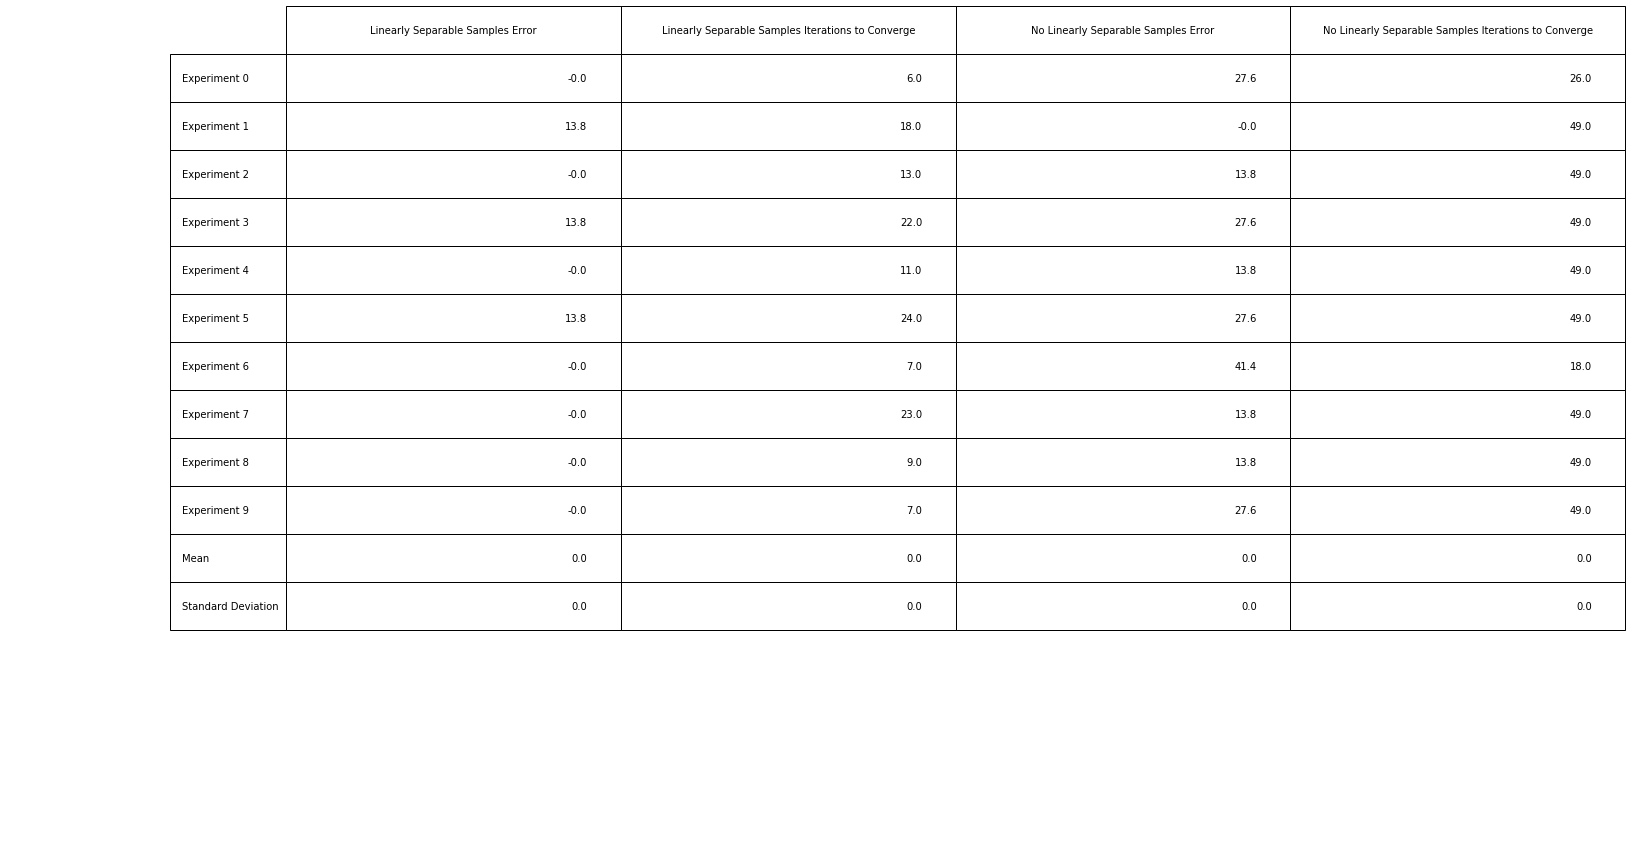

In [3]:
def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [6, 6], stds1 = [3, 3], stds2 = [2, 1]):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2
    """
    means = torch.zeros(2)

    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]

    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
        
    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)

    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1], marker='^', c='blue')
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker='o', c='orange')

    plt.show()
    
    # Create samples with bias
    samplesAllBias = torch.cat((samplesClass1Bias, samplesClass2Bias), 0)
    
    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = 0 * torch.ones(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)
    
    return (targetsAll, samplesAllBias)


def createDataOneClass(means, covarianceMatrix, numberSamples):
    """
    Creates data with gaussian distribution
    """
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
    return samples

def sigmoid(x):
    """
    Sigmoid activation function
    """
    return 1/(1+np.exp(-x))

def forward(samples, w, threshold=0.5, lowerLimit = 0, upperLimit = 1):
    """
    Get model output.
    param samples: samples used to estimated targets. 
    param w: network's weights. 
    param threshold: neuron's threshold of the transfer function.
    param lowerLimit: lower limit of the transfer function.
    param upperLimit: upper limit of the transfer function.
    return: Estimates the model outputs using the sigmoid activation function with values of lowerLimit and upperLimit.   
    """

    # Define vectorize sigmoid to apply to m*w
    vectorize_sigmoid = np.vectorize(sigmoid)
    EstimatedTargets = samples.mm(w)
    
    # Apply sigmoid function to m*w
    EstimatedTargets = torch.from_numpy(vectorize_sigmoid(EstimatedTargets.numpy())).type(torch.FloatTensor)
    
    # Classify predictions
    EstimatedTargets[EstimatedTargets>threshold] = upperLimit
    EstimatedTargets[EstimatedTargets<=threshold] = lowerLimit
    
    return EstimatedTargets

def vectorTransposed(w):
    """
    Calculate the transposed of a vector.
    return: the transposed vector.   
    """
    w2Drow = w.reshape(-1, w.shape[0])
    return w2Drow.transpose(0, 1)  

def calculateError(targets, estimated_targets):
    """
    Calculate the cost using the versimilitude error. 
    """
    cost = ((targets*torch.log((estimated_targets+0.1e-5))) + (1-targets)*torch.log((1-estimated_targets + 0.1e-5)))
    return -torch.sum(cost)

def train_model(samples, targets, epochs=10):
   """
   Train the logistic regression model adjusting the neural network's weights.
   param samples: Conjunction of entries
   param targets: Types of clases (Class 1 and Class 2)
   param epochs: number of training cycles.
   return: updated weights   
   """

   def updateDeltaWeight(samples, targets_transpose, estimated_targets_transpose, wT, alpha=0.1):
      """
      Estimate delta weight using stochastic gradient descent
      param SamplesAllBias: NumSamples x NumDimensions 
      param TargetsAllT: NumSamples' clases 
      param EstimatedTargetsAllT: estimated clases
      param wT: previous weights
      param eta: learning rate
      
      return: updated weights.   
      """
      samples_transpose = samples.transpose(0, 1)    
      return wT + alpha * samples_transpose.mm(targets_transpose - estimated_targets_transpose)
   

   # Generate random weights
   samples_dimensions = samples.size()
   w = torch.ones(samples_dimensions[1],1)
   wT = vectorTransposed(w)

   # Calculate Targets transpose 
   targets_transpose = vectorTransposed(targets)
   
    
   # Train during n epochs
   epochToConv = epochs
   for epoch in range(epochs):
       # Calculate predictions (estimated targets)
       estimated_targets_transpose = vectorTransposed(forward(samples, wT))
       
       # Calculate error
       error  = calculateError(targets_transpose, estimated_targets_transpose)
       print('>epoch=%d, cost=%.3f' % (epoch, error))
        
       if error > 0.1e-5 :  
          # Update weights 
          wT = updateDeltaWeight(samples, targets_transpose, estimated_targets_transpose, wT)
          epochToConv=epoch  

       #epoch = epoch + 1

   return wT, epochToConv


def plotErrorTable(error, collabel, rows) : 
    #plot errors
    fig, ax = plt.subplots()

    # Hide axes
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.axis("off")    
    
    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(collabel))
    
    #Row's labels    
    #rows = ['Muestras %d' % x for x in rowlabels]
      
    # Create text labels for the table
    cell_text = []

    data =error.numpy()
    n_rows = len(data)
       
    for row in range(n_rows):
        y_offset = np.zeros(len(collabel))
        y_offset =  y_offset + data[row]
        cell_text.append(['%1.1f' % x for x in y_offset])
        
    the_table = ax.table(cellText=cell_text,rowLabels=rows, colLabels=collabel,loc='top')     

    #the_table.auto_set_font_size(False)
    the_table.set_fontsize(24)
    the_table.scale(4, 4)
    
    return


# Test the logistic regression model  
def logistic_regression(samples, targets, epochs = 50, test_size = 0.3):    

    # Define the set of training samples as 70% (randomly selected) and test samples as 30%.
    X_train, X_test, Y_train, Y_test = tts(samples.numpy(), targets.numpy(), test_size = test_size)

    # Train the logistic regression model
    wF, epochToConv = train_model(torch.tensor(X_train), torch.tensor(Y_train), epochs=epochs)

    # Test the trained logistic regression model
    Estimated_Y = forward(torch.tensor(X_test), wF)

    # Calculate error
    testError = calculateError(torch.tensor(Y_test), Estimated_Y )
    print("Error total para el conjunto de muestras:", testError)
    return testError, epochToConv
  

def test_logistic_regression():
    totalEpochs = 50
    samplesPerClass = 1000
    experiments = 10
    
    #vector with all experiments' errors 
    vExperimentError= torch.zeros(experiments+2,4)    
    
    #Table definition
    collabel=('Linearly Separable Samples Error', 'Linearly Separable Samples Iterations to Converge', 'No Linearly Separable Samples Error', 'No Linearly Separable Samples Iterations to Converge')
    rowslabel = ['Experiment %d' % x for x in range(0, experiments)] 
    rowslabel.append('Mean') 
    rowslabel.append('Standard Deviation')
 
    
    for i in range(0, experiments):

      # Sample data type 1. Linearly separable
      print("Sample data linearly separable")
      (targets, samples) = createData(numberSamplesPerClass = samplesPerClass, mean2 = [13, 13])
      finalError, epochToConv = logistic_regression(samples, targets, epochs = totalEpochs, test_size = 0.3)
      vExperimentError[i][0] = finalError
      vExperimentError[i][1] = epochToConv

      # Sample data type 2. No linearly separable
      print("Sample data linearly separable")
      (targets, samples) = createData(numberSamplesPerClass = samplesPerClass, mean2 = [8, 8])
      finalError, epochToConv = logistic_regression(samples, targets, epochs = totalEpochs, test_size = 0.3)
      vExperimentError[i][2] = finalError
      vExperimentError[i][3] = epochToConv

    print("======================================")
    print("PARAMETERS")
    print("--- Epochs: ", totalEpochs)
    print("--- Samples per class: ", samplesPerClass)
    print("--- Experiments: ", experiments)    
    print("======================================")

  
    plotErrorTable(vExperimentError, collabel, rowslabel)

    
test_logistic_regression()

#¿Cuál de las funciones matemáticas vistas en clase puede utilizarse a la salida del regresor logístico para realizar una clasificación binaria?
Se puede utilizar la función sigmoidal ya es una función suave y continua acotada entre 0 y 1.




## 2. Experimentos, análisis y el enfoque de mínimos cuadrados regularizado. (60 puntos)

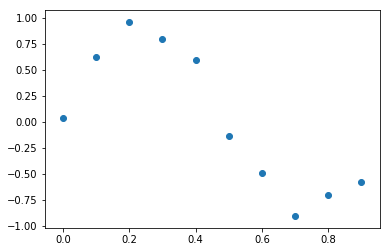

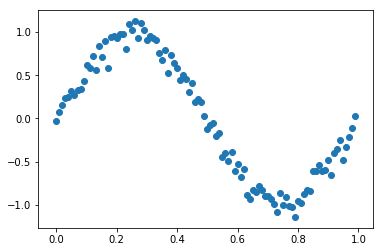

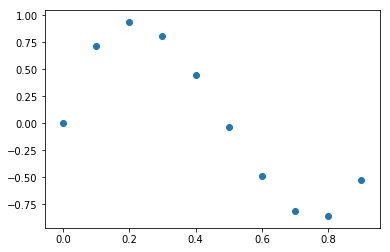

In [0]:
"""
Creates the observation array t, from a sinusoidal wave
@param x, the x values 
@param stdNoise, standard d
eviation of noise, hihger, lower signal to noise ratio
@return (t, yReal), the observed values and the original signal without noise
"""                 
def generate_signal(x, stdNoise=0.1):
    yReal = np.sin(2* np.pi * x);
    # Create noise
    noise = np.random.normal(0, stdNoise, yReal.shape);
    # Additive gaussian noise                        
    t = yReal + noise;
    return (t, yReal);
  
def generate_x_values(n=10):
    maximum_value = 1
    x = np.arange(0, maximum_value, 1/(n/maximum_value));   
    # x = np.concatenate((x, np.array([maximum_value])));
    return x
  
def plotSignal(x, y):
    # Scatter of the noisy signal
    plt.scatter(x, y);
    plt.show()
    
def power_matrixA_data(x, degree):
    x_power = np.power(x, degree)
    return np.sum(x_power)
  
def power_matrixB_data(x, t, degree):
    x_power = np.power(x, degree)
    multiply_factor = np.multiply(x_power, t)
    return np.sum(multiply_factor)
    
def getOptimumWReg(x, t, M=3, lambdaF=0.5):
    # Create base matrix A
    A = np.ones((M+1, M+1))
    for i in range(0, M+1):
      for j in range(0, M+1):
        A[i][j] = power_matrixA_data(x, i + j)
    
    # Create matrix B
    B = torch.ones(M+1, 1)
    B = B.numpy()
    for i in range(0, M+1):
      B[i] = power_matrixB_data(x, t, i)
      
    # Translate as Torch Tensor
    A = torch.from_numpy(A).type(torch.FloatTensor)
    B = torch.from_numpy(B)
    
    return A.inverse().mm(B);

def plot_fit(x, wOpt, N, M):
    y = np.zeros(N)
    w = wOpt.transpose(0, 1)
    w = w.numpy()[0]

    for i in range(0, N):
      sum_value = 0
      for j in range(0, M+1):
        sum_value += w[j]*(x[i]**j)
      y[i] = sum_value
      
    plt.scatter(x, y);
    plt.show()

def test_exercise2():
    # Dataset 1
    x1 = generate_x_values(n=10)
    (t1, yReal) = generate_signal(x1);
    plotSignal(x1, t1)
    
    # Dataset 2
    x2 = generate_x_values(n=100)
    (t2, yReal) = generate_signal(x2);
    plotSignal(x2, t2)
    
    # Get optimum value
    wOpt = getOptimumWReg(x1, t1, M=3, lambdaF=0.5)
    
    # Plot Fit Y Estimated
    plot_fit(x1, wOpt, N=10, M=3)
    
    
test_exercise2()